In [12]:
%matplotlib inline
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import numpy as np
import pyrfume
from pyrfume import pubchem
import re
import requests
from tqdm.auto import tqdm

In [2]:
def update_results(records, results):
    keywords = ('odor', 'odour', 'smell', 'aroma ', 'aroma,', 'aroma.', 'fragrance')
    for annotation in records['Annotations']['Annotation']:
        try:
            cids = annotation['LinkedRecords']['CID']
        except:
            pass
        else:
            strings = [] 
            for x in annotation['Data']:
                for y in x['Value']['StringWithMarkup']:
                    if any([z in y['String'].lower() for z in keywords]):
                        strings.append(y['String'])
            for cid in cids:
                if cid in results:
                    results[cid] += strings
                elif strings:
                    results[cid] = strings

In [3]:
def get_results(heading):
    page = 1
    results = {}
    with tqdm(total=100) as pbar:
        while True:
            url = (f"https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/annotations/heading/"
                   f"JSON?heading_type=Compound&heading={heading}&page={page}")
            response = requests.get(url)
            records = response.json()
            update_results(records, results)
            totalPages = records['Annotations']['TotalPages']
            if page==1:
                pbar.reset(total=totalPages)
            pbar.set_description("%d CIDs described" % len(results))
            pbar.update()
            page += 1
            if page > totalPages:
                break
    return results

In [4]:
pd_results = get_results("Physical+Description")

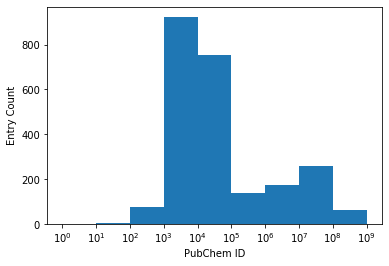

In [6]:
def make_hist(results):
    plt.hist(np.log10(list(results.keys())), bins=np.arange(10));
    xticks = np.arange(10)
    plt.xticks(xticks, ['$10^%d$' % x for x in xticks]);
    plt.xlabel('PubChem ID')
    plt.ylabel('Entry Count')
    
make_hist(pd_results)

In [7]:
rd_results = get_results("Record+Description")

In [8]:
rd_cids = set(key for key in rd_results)
pd_cids = set(key for key in pd_results)
len(rd_cids), len(pd_cids), len(rd_cids.difference(pd_cids)), len(pd_cids.difference(rd_cids))

(2455, 2386, 560, 491)

In [10]:
all_statements = {}
cids = sorted(set(rd_cids) | set(pd_cids))
for cid in cids:
    rs = rd_results.get(cid, [])
    ps = pd_results.get(cid, [])
    all_statements[cid] = rs + ps
len(all_statements)

2946

In [15]:
def color(cid, s, code):
    return "<p style='color: %s'>%d: %s</p>" % (code, cid, s)

# 'aroma' needs the trailing space to avoid matching 'aromatic'
odorous_phrases = ['odor', 'odour', 'smell', 'fragrance', 'aroma ', 'sense of smell']
odorless_phrases = ['no odor', 'no odour', 'no smell', 'no fragrance', 'odorless', 'odourless']
ambiguous_phrases = ['odoratus']

def make_html(all_statements):
    html = ""
    for cid, statements in all_statements.items():
        for statement in statements:
            statement = statement.lower()
            if any([re.findall(phrase, statement) for phrase in odorless_phrases]):
                html += color(cid, statement, '#DD0000')
            elif any([re.findall(phrase, statement) for phrase in ambiguous_phrases]):
                html += color(cid, statement, '#000000')
            elif any([re.findall(phrase, statement) for phrase in odorous_phrases]):
                html += color(cid, statement, '#009900')
            else:
                html += color(cid, statement, '#000000')
    return html

html = make_html(all_statements)
#display(HTML(html))
with open('../data/pubchem/pubchem_scrape.html', 'w') as f:
    f.write(html)

In [16]:
path = 'pubchem/pubchem_scrape.pkl'
pyrfume.save_data(all_statements, path)